In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
data = pd.read_excel ("Daily.xlsx")


data.head()

,Date,Open,High,Low,Close,Tick Volume,Volume,Spread
0,2004.06.11,384.0,384.8,382.8,384.1,303,0,0
1,2004.06.14,384.3,385.8,381.8,382.8,1954,0,0
2,2004.06.15,382.8,388.8,381.1,388.6,1995,0,0
3,2004.06.16,387.1,389.8,382.6,383.8,2106,0,0
4,2004.06.17,383.6,389.3,383.0,387.6,1638,0,0


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Define sequence length (e.g., 60 days)
seq_length = 60

X, y = create_sequences(scaled_data, seq_length)

# Reshape X to fit LSTM input shape (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
train_size = int(len(X) * 0.8)  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))

# Add dense layers
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))
history

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - loss: 0.0100 - val_loss: 6.2885e-04
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 1.8419e-04 - val_loss: 4.3904e-04
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 1.7485e-04 - val_loss: 3.8400e-04
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 1.8554e-04 - val_loss: 4.9709e-04
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 1.5369e-04 - val_loss: 6.4212e-04
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 1.4126e-04 - val_loss: 2.6527e-04
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.1524e-04 - val_loss: 5.4101e-04
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 1.2234e-04 - val_loss: 3.7208e-04
Epoch 9/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 1.0505e-04 - val_loss: 2.4906e-04
Epoch 10/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 9.5216e-05 - val_loss: 1.9334e-04
Epoch 11/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 56m

In [ ]:

def rsmpescore(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate symmetric absolute percentage errors
    symmetric_errors = np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)

    # Calculate SMPE (Symmetric Mean Percentage Error)
    smpe = np.mean(symmetric_errors)

    # Calculate RSMPE (Root SMPE)
    rsmpe = np.sqrt(smpe)

    return rsmpe

In [ ]:
from sklearn.metrics import r2_score
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the scaled predictions and actual values
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
r2 = r2_score(y_test_actual, predictions)
rsmpe = rsmpescore(y_test_actual, predictions)

# Print the result
print(f"R² Score: {r2}")
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f"RSMPE: {rsmpe*100:.2f}%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
R² Score: 0.978086778337117
Root Mean Squared Error (RMSE): 46.967565303954466
RSMPE: 13.67%


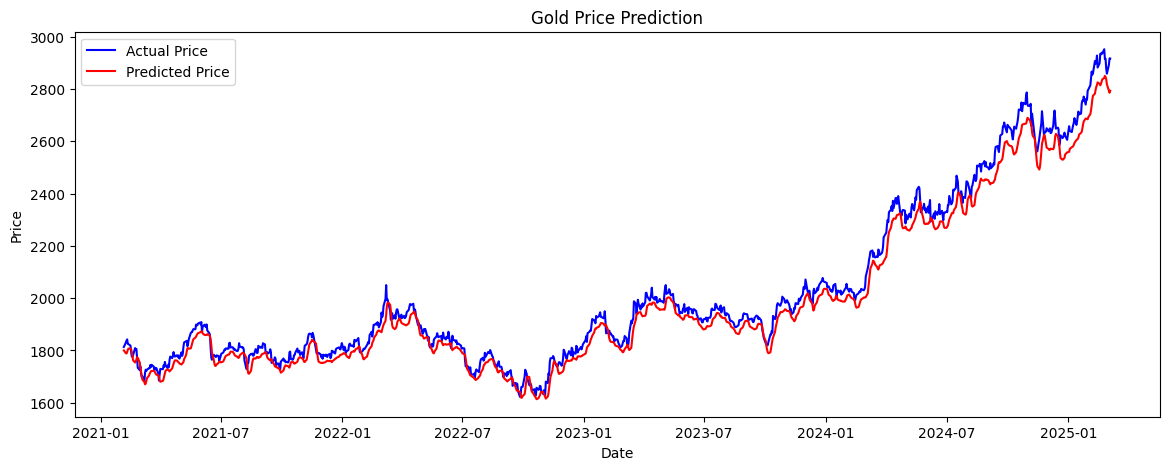

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(data.index[-len(y_test):], y_test_actual, label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):], predictions, label='Predicted Price', color='red')
plt.title('Gold Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()